#Step 1: Upload image file of BU schedule

In [1]:
from google.colab import files

In [2]:
my_image = files.upload()

Saving sample2.jpg to sample2.jpg


In [3]:
my_path = list(my_image.keys())[0]

In [4]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!sudo apt install tesseract-ocr-eng

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,190 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

# Step 2: Define custom schedule object

In [5]:
from datetime import datetime, timedelta

class Schedule:
    def __init__(self):
        # Initialize an empty schedule
        self.schedule = {}

    def add_busy_time(self, start_time, end_time, activity):
        # Convert time strings to datetime objects
        start_datetime = datetime.strptime(start_time, "%I:%M%p")
        end_datetime = datetime.strptime(end_time, "%I:%M%p")

        # Check if the time range overlaps with existing busy times
        for busy_start, busy_end, current_activity in self.schedule.values():
            if (start_datetime < busy_end) and (end_datetime > busy_start):
                print(f"{activity} from {start_time} to {end_time} conflicts with {current_activity} from {busy_start.strftime('%I:%M%p').lower()} to {busy_end.strftime('%I:%M%p').lower()}.")
                return False
        if (end_datetime <= start_datetime):
            print(f"This activity, {activity}, will end at {end_time} the next day.")
            end_datetime = datetime.strptime("12:00am", "%I:%M%p")

        # Add the new busy time to the schedule
        self.schedule[start_time] = (start_datetime, end_datetime, activity)
        return True

    def add_sleep_time(self, start, end):
        self.add_busy_time(start, end, "Sleep")
        return True

    def display_schedule(self):
        print("Busy times:")
        sorted_schedule = sorted(self.schedule.items(), key=lambda x: x[1][0])
        for start_time, (start_datetime, end_datetime, activity) in sorted_schedule:
            print(f"{start_time} - {end_datetime.strftime('%I:%M%p').lower()}: {activity}")
        return

    def __str__(self):
        if self.isEmpty():
          return f"This day has a completely free schedule!\n"
        else:
          s = '\n'
          sorted_schedule = sorted(self.schedule.items(), key=lambda x: x[1][0])
          for start_time, (start_datetime, end_datetime, activity) in sorted_schedule:
            s += f"{start_time} - {end_datetime.strftime('%I:%M%p').lower()}: {activity}\n"
          return s

    def isEmpty(self):
      if self.schedule:
        return False
      else:
        return True

    def get_free_times(self):
        free_times = []
        sorted_schedule = sorted(self.schedule.values(), key=lambda x: x[0])
        prev_end_time = datetime.strptime("12:00am", "%I:%M%p")
        for start_time, end_time, _ in sorted_schedule:
            if start_time > prev_end_time:
                free_times.append((prev_end_time.strftime('%I:%M%p').lower(), start_time.strftime('%I:%M%p').lower()))
            prev_end_time = max(prev_end_time, end_time)
        if prev_end_time < datetime.strptime("12:00am", "%I:%M%p"):
            free_times.append((prev_end_time.strftime('%I:%M%p').lower(), "12:00am"))
        return free_times


    def add_activity_duration(self, activity, total_duration):
        free_times = self.get_free_times()

        # Iterate over free time ranges
        for start_time, end_time in free_times:
            start_datetime = datetime.strptime(start_time, "%I:%M%p")
            end_datetime = datetime.strptime(end_time, "%I:%M%p")

            # Calculate the duration of the current free time slot
            duration = (end_datetime - start_datetime).total_seconds() / 3600  # Convert to hours

            # If there's enough free time to add the entire activity
            if duration >= total_duration:
                self.add_busy_time(start_time, (start_datetime + timedelta(hours=total_duration)).strftime("%I:%M%p"), activity)
                return

            # If there's not enough free time to add the entire activity, add the activity for the available free time
            else:
                self.add_busy_time(start_time, end_time, activity)
                total_duration -= duration


In [6]:
def schedule_activity(s, activity, duration_per_day, days):
  for day in days:
    s[day].add_activity_duration(activity, duration_per_day)

def schedule_sleep(start, end, s, days):
  for day in days:
    s[day].add_sleep_time(start, end)

def ask_schedule():
  activity = input("Please enter the activity that you would like to do: ")
  time_per_day = input("How many hours per day would you like to do it? ")
  days_of_the_week = input("Which day(s) of the week would you like to do it? (Options: Mon, Tue, Wed, Thu, Fri, Sat, Sun) ")
  return activity, time_per_day, days_of_the_week

def implement_custom_activity(s):
 activity, hours, days = ask_schedule()
 schedule_activity(s, activity, hours, days)

# Step 3: Pytesseract OCR scanning

In [7]:
import pytesseract
from PIL import Image

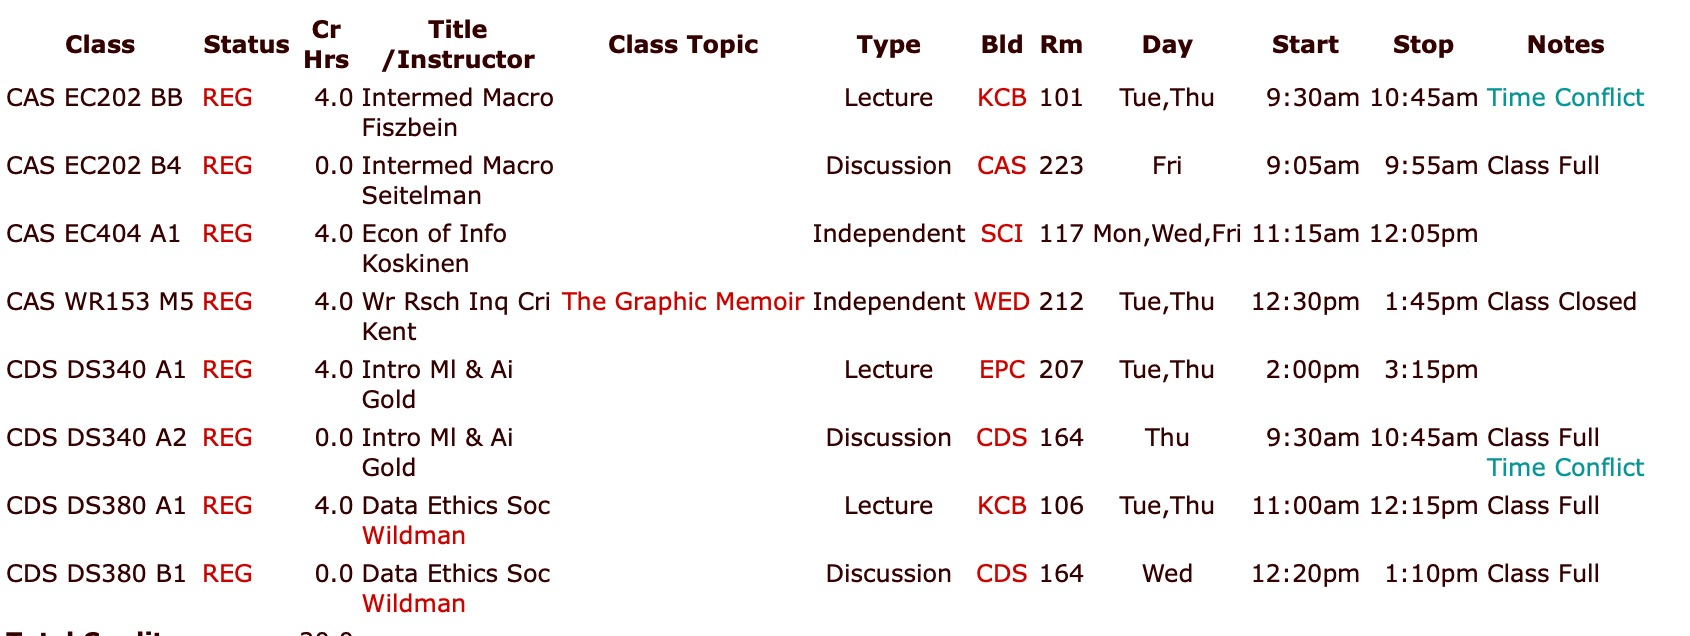

In [8]:
Image.open(my_path)

In [9]:
x = pytesseract.image_to_string(Image.open(my_path))

# Step 4: Use regular expressions to extract information

In [10]:
import re

time_start_stop_pairs = [s.split(' ')for s in re.findall("\d+:\d\d[ap]m \d+:\d\d[ap]m", x)]

for l in time_start_stop_pairs:
  l.append("Class")

pattern = r'(?<=\s)(?!\d{1,2}:\d{2}(?:am|pm))(\S+?)(?=\s\d{1,2}:\d{2}(?:am|pm))'

dates = re.findall(pattern, x)

In [11]:
dates_split = [s.split(',') for s in dates]
dates_split

[['Tue', 'Thu'],
 ['Fri'],
 ['Mon', 'Wed', 'Fri'],
 ['Tue', 'Thu'],
 ['Tue', 'Thu'],
 ['Thu'],
 ['Tue', 'Thu'],
 ['Wed']]

In [12]:
times_dates = list(zip(dates_split, time_start_stop_pairs))

# Step 5: Construct schedule with class times (and sleep times)

In [13]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [22]:
schedule = {day: Schedule() for day in days}

In [23]:
for day in days:
  schedule[day].add_sleep_time("12:00am", "6:00am")

In [24]:
for l1, l2 in times_dates:
  for day in l1:
    schedule[day].add_busy_time(l2[0], l2[1], l2[2])

Class from 9:30am to 10:45am conflicts with Class from 09:30am to 10:45am.


In [25]:
for day in days:
  print(f"{day}: {schedule[day]}")

Mon: 
12:00am - 06:00am: Sleep
11:15am - 12:05pm: Class

Tue: 
12:00am - 06:00am: Sleep
9:30am - 10:45am: Class
11:00am - 12:15pm: Class
12:30pm - 01:45pm: Class
2:00pm - 03:15pm: Class

Wed: 
12:00am - 06:00am: Sleep
11:15am - 12:05pm: Class
12:20pm - 01:10pm: Class

Thu: 
12:00am - 06:00am: Sleep
9:30am - 10:45am: Class
11:00am - 12:15pm: Class
12:30pm - 01:45pm: Class
2:00pm - 03:15pm: Class

Fri: 
12:00am - 06:00am: Sleep
9:05am - 09:55am: Class
11:15am - 12:05pm: Class

Sat: 
12:00am - 06:00am: Sleep

Sun: 
12:00am - 06:00am: Sleep



# Step 6: Enter what activities you want to do and for how long, and those activities will be fit into your schedule!

Using the schedule_activity function, you can input your desired activity, how many hours per day you want to do it, and on what days you want to do it. The algorithm will find a spot in your schedule for these activities if they fit.

In [25]:
# Examples of adding activities
schedule_activity(schedule, "Read", 5, ['Mon', "Thu"])
schedule_activity(schedule, "Gym", 2, days)

# Step 7: See your updated schedule with your desired activities added!

In [26]:
for day in days:
  print(f"{day}: {schedule[day]}")

Mon: 
12:00am - 06:00am: Sleep
06:00am - 11:00am: Read
11:00am - 11:15am: Read
11:15am - 12:05pm: Class

Tue: 
12:00am - 06:00am: Sleep
06:00am - 08:00am: Gym
9:30am - 10:45am: Class
11:00am - 12:15pm: Class
12:30pm - 01:45pm: Class
2:00pm - 03:15pm: Class

Wed: 
12:00am - 06:00am: Sleep
06:00am - 08:00am: Gym
11:15am - 12:05pm: Class
12:20pm - 01:10pm: Class

Thu: 
12:00am - 06:00am: Sleep
06:00am - 09:30am: Read
9:30am - 10:45am: Class
10:45am - 11:00am: Read
11:00am - 12:15pm: Class
12:15pm - 12:30pm: Read
12:30pm - 01:45pm: Class
01:45pm - 02:00pm: Read
2:00pm - 03:15pm: Class

Fri: 
12:00am - 06:00am: Sleep
06:00am - 08:00am: Gym
9:05am - 09:55am: Class
11:15am - 12:05pm: Class

Sat: 
12:00am - 06:00am: Sleep

Sun: 
12:00am - 06:00am: Sleep

